In [80]:
import numpy as np
import sklearn as sk
import sklearn.preprocessing as pr
import sklearn.manifold as mani
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

import MyLib
from MyLib import Data
%matplotlib inline


In [3]:
x_train = pd.read_csv('x_train.csv',sep=';')
y_train = pd.read_csv('y_train.csv',sep=';',names=['value'])

data = Data(x_train,y_train)
data.scale()

array([[ 1.01995513, -0.18596511, -0.07501825, ..., -0.35172113,
        -0.20013259, -0.26219928],
       [ 0.12765415,  0.73770604,  2.2895672 , ...,  0.77734016,
         0.82017202,  0.4610509 ],
       [-0.66550227, -0.49385549, -0.37059143, ..., -0.45541043,
        -0.43820366, -0.62382437],
       ..., 
       [-0.61593   , -0.4168829 , -0.22280484, ..., -0.35172113,
        -0.37018335, -0.62382437],
       [ 1.81311155, -0.87871847, -0.37059143, ..., -0.98537798,
        -0.88033565, -0.62382437],
       [-0.86379138, -0.80174588, -0.37059143, ..., -0.75495731,
        -0.81231535, -0.62382437]])

In [4]:
#Universal testing function
def test_alg(algo,X=data.X,y=data.y,test_size = 0.2,desc = True):  
        # X=X will use your global X defined above. 
        
    x_train_, x_test_, y_train_, y_test_ = sk.model_selection.train_test_split(X,y,test_size=test_size)
    #fitting the model
    algo.fit(x_train_,y_train_)
    y_pred = algo.predict_proba(x_test_)
    #return log loss
    metrics = sk.metrics.log_loss(y_test_,y_pred)
    s= "result: "+str(metrics)
    if desc:
        s = s+" \n\nAlgorithm info:\n"+str(algo)
    print s
    return algo

def scor_logloss(estimator,X,y):
    pr = estimator.predict_proba(X)
    return sk.metrics.log_loss(y,pr)

def test_alg_cv(algo,X=data.X,y=data.y,test_size = 0.2,desc = True,cv=5):  
    # X=X will use your global X defined above. 
    #return log loss
    cv_score = sk.model_selection.cross_val_score(algo,X,y,scoring=scor_logloss,cv=cv)
    s= "result: "+str(cv_score.mean())+str(np.std(cv_score))
    if desc:
        s = s+" \n\nAlgorithm info:\n"+str(algo)
    print s
    return algo,cv_score

### Stacking clf


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier

In [6]:
clf1 = KNeighborsClassifier(n_neighbors=100)
clf2 = RandomForestClassifier(n_estimators=50,max_depth=4,random_state=1)
clf3 = MLPClassifier(hidden_layer_sizes=(25,1))
lr = RandomForestClassifier(n_estimators=100,max_depth=5)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'MLPClassifier',
                       'StackingClassifier']):

    scores = sk.model_selection.cross_val_score(clf, data.X, data.y, 
                                              cv=3, scoring=scor_logloss)
    print("Accuracy: %0.5f (+/- %0.5f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.41114 (+/- 0.00968) [KNN]
Accuracy: 0.38949 (+/- 0.00146) [Random Forest]
Accuracy: 0.38537 (+/- 0.00120) [MLPClassifier]
Accuracy: 0.43858 (+/- 0.00434) [StackingClassifier]


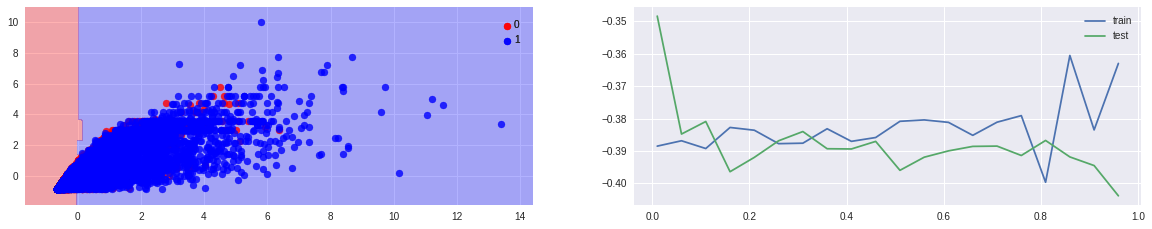

In [15]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_learning_curves

import matplotlib.gridspec as gridspec
import itertools
clf2 = RandomForestClassifier(n_estimators=15,max_depth=4)
clf2.fit(data.X[:,[3,1]], data.y)
train,test = data.get_train_test()
plt.figure(figsize=(20,8))
plt.subplot(221)
fig = plot_decision_regions(X=data.X[:,[3,1]], y=data.y, clf=clf2,markers='o')
plt.subplot(222)
learning_curves(data.X,data.y,clf = clf2)

## XGBOOST

In [7]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/home/jesse/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jesse/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## generating new features

In [8]:
def gen_new_features(df):
    x_train = df
    df['bonus_in_overall']=  x_train['totalBonusScore']/(1+x_train['totalScore'])
    df['score_per_day'] = x_train['totalScore']/x_train['numberOfDaysActuallyPlayed']
    df['star_in_bonus'] = x_train['totalStarsCount']/(1 + x_train['totalBonusScore'])
    df['top_to_all'] =x_train['attemptsOnTheHighestLevel']/x_train['totalNumOfAttempts']
    df['avg_attemps'] =x_train['numberOfAttemptedLevels']/x_train['totalNumOfAttempts']
    return df
def gen_log_features_fordata(data_side):
    data_log = data_side.log_x()
    X  = np.concatenate((data_log.X,data_side.X),axis = 1)
    return Data(X,data.y)

In [64]:
x_train = pd.read_csv('x_train.csv',sep=';')
y_train = pd.read_csv('y_train.csv',sep=';',names=['value'])

data = Data(x_train,y_train)
data_side= Data(gen_new_features(data.df_X),data.y)
data_side = gen_log_features_fordata(data_side)
data.scale()
data_side.scale()
data_side.describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,...,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04,2.528900e+04
mean,3.087850e-16,2.900303e-16,2.818120e-16,-2.138877e-16,1.413275e-16,-1.019918e-16,5.443776e-16,9.201738e-18,2.590535e-16,-9.496755e-17,...,-7.192809e-17,-6.876719e-17,-7.136615e-17,-2.683255e-17,-9.328174e-17,-3.180570e-16,8.358830e-17,1.334603e-18,-3.624501e-17,-1.275600e-16
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,...,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.944774e+00,-1.609757e+00,-1.554887e+00,-3.700983e+00,-1.267003e+00,-5.384064e+00,-4.394038e+00,-2.014307e+00,-7.686752e-01,-9.133637e-01,...,-1.330177e+00,-8.445122e-01,-9.853780e-01,-9.143458e-01,-6.238244e-01,-1.991948e+00,-1.115400e+00,-9.925417e-02,-9.463781e-01,-2.593433e+00
25%,-6.211750e-01,-8.618316e-01,-8.033039e-01,-3.776638e-01,-1.267003e+00,-2.941052e-01,-4.141764e-01,-5.510486e-01,-7.686752e-01,-7.150745e-01,...,-1.330177e+00,-7.030901e-01,-7.203942e-01,-7.102849e-01,-6.238244e-01,-6.172892e-01,-7.984072e-01,-5.761687e-02,-6.830208e-01,-8.128022e-01
50%,9.880882e-02,1.318455e-02,-1.954967e-02,3.694134e-01,-1.697347e-01,1.952850e-01,1.855347e-01,1.998113e-01,-7.686752e-01,-3.680686e-01,...,2.094257e-01,-3.467531e-01,-2.941160e-01,-3.021630e-01,-6.238244e-01,-3.191602e-01,-2.011642e-01,-4.568726e-02,-4.086136e-01,1.914256e-01
75%,7.956250e-01,6.994341e-01,7.193167e-01,6.440561e-01,6.765266e-01,5.172167e-01,5.926990e-01,7.210345e-01,4.618055e-01,4.250878e-01,...,1.156873e+00,2.944777e-01,3.395409e-01,3.440299e-01,9.942581e-02,3.062481e-01,4.862136e-01,-4.178337e-02,1.402008e-01,9.948079e-01
max,2.159349e+00,2.997365e+00,3.072863e+00,1.806819e+00,3.134325e+00,1.328646e+00,1.928327e+00,2.323275e+00,2.808198e+00,6.324189e+00,...,1.156873e+00,8.331237e+00,1.020155e+01,9.934893e+00,4.077302e+00,2.442320e+00,1.126749e+01,5.218206e+01,2.335459e+00,9.948079e-01


plot for 


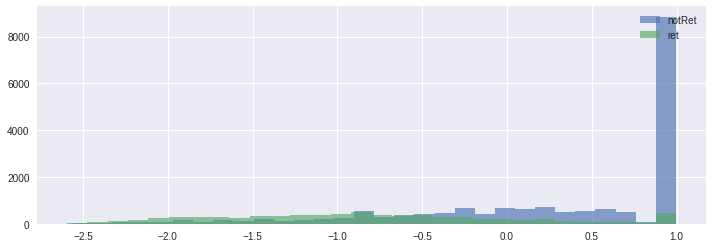

In [9]:
data_side.plot_hist(25)

In [10]:
train,test = data_side.get_train_test()


dtrain = xgb.DMatrix(train[0], label=train[1])
dtest = xgb.DMatrix(test[0],label=test[1])

param = {'max_depth':4,
         'alpha':0.00002,
         'eta':0.1, 
         'silent':1,
         'gamma':0.01,
         'scale_pos_weight':1,
         'colsample_bytree':1,
         'subsample':0.8,
         'min_child_weight':4
        }
param['nthread'] = 6
param['eval_metric'] = 'logloss'
param['objective']='binary:logistic'

evallist  = [(dtest,'eval'), (dtrain,'train')]


In [13]:
xgbost = XGBClassifier(param)

In [17]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,1)
}
gsearch2 =GridSearchCV(estimator = xgbost, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=4,verbose=1)
    
gsearbch2.fit(data_side.X,data_side.y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.2min finished


([mean: -0.38337, std: 0.00708, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.38329, std: 0.00738, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -0.38322, std: 0.00731, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.38317, std: 0.00738, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.38333, std: 0.00749, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.38650, std: 0.00777, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.38636, std: 0.00768, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.38605, std: 0.00786, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.38582, std: 0.00781, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.38575, std: 0.00710, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.39204, std: 0.00804, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.39254, std: 0.00743, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: -0.39147, std: 0.008

In [19]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[3,4,5]
}
gsearch2 = GridSearchCV(estimator = xgbost, 
 param_grid = param_test2, scoring='neg_log_loss',iid=False, cv=4,verbose=1)
    
gsearch2.fit(data_side.X,data_side.y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   18.3s finished


([mean: -0.38344, std: 0.00695, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.38337, std: 0.00694, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.38328, std: 0.00690, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: -0.38322, std: 0.00731, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.38317, std: 0.00738, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.38333, std: 0.00749, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.38399, std: 0.00731, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.38406, std: 0.00745, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.38426, std: 0.00779, params: {'max_depth': 4, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 4},
 -0.3831711945579642)

In [22]:
param_test2b = {
 'min_child_weight':[11,12,13]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=4, gamma=0.01, reg_alpha=0.0002,subsample=0.8, colsample_bytree=1,
 objective= 'binary:logistic', nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='neg_log_loss',iid=False, cv=4,verbose=1)

gsearch2b.fit(data_side.X,data_side.y)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    9.6s finished


([mean: -0.38314, std: 0.00779, params: {'min_child_weight': 11},
  mean: -0.38293, std: 0.00766, params: {'min_child_weight': 12},
  mean: -0.38311, std: 0.00740, params: {'min_child_weight': 13}],
 {'min_child_weight': 12},
 -0.38292736820629275)

In [27]:
param_test3 = {
 'gamma':[i/10.0 for i in range(3,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=12, gamma=0.01, subsample=0.8, colsample_bytree=1,
 objective= 'binary:logistic', reg_alpha=0.0002,nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_log_loss',iid=False, cv=5,verbose =1)
gsearch3.fit(data_side.X,data_side.y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   30.4s finished


([mean: -0.38270, std: 0.01049, params: {'gamma': 0.3},
  mean: -0.38269, std: 0.01050, params: {'gamma': 0.4},
  mean: -0.38267, std: 0.01049, params: {'gamma': 0.5},
  mean: -0.38266, std: 0.01050, params: {'gamma': 0.6},
  mean: -0.38266, std: 0.01050, params: {'gamma': 0.7},
  mean: -0.38266, std: 0.01047, params: {'gamma': 0.8},
  mean: -0.38266, std: 0.01047, params: {'gamma': 0.9}],
 {'gamma': 0.8},
 -0.3826575207799635)

    test-logloss-mean  test-logloss-std  train-logloss-mean  train-logloss-std
0            0.645672          0.000279            0.645469           0.000225
1            0.606651          0.000557            0.606265           0.000395
2            0.574330          0.000898            0.573780           0.000588
3            0.547229          0.001096            0.546461           0.000713
4            0.524225          0.001443            0.523251           0.000751
5            0.504856          0.001562            0.503643           0.000749
6            0.488256          0.001811            0.486932           0.000800
7            0.474174          0.001885            0.472634           0.000871
8            0.462004          0.002163            0.460256           0.000889
9            0.451418          0.002324            0.449607           0.000953
10           0.442281          0.002471            0.440356           0.001001
11           0.434419          0.002544            0

/home/jesse/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jesse/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
logloss : 0.3742
logloss (Train): 0.374190


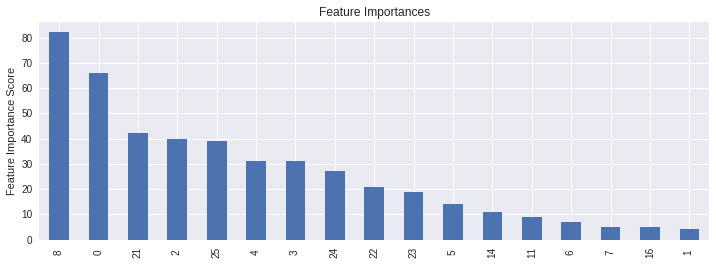

In [40]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.8,
 reg_alpha = 0.002,
 subsample=0.8,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=6,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, data_side, predictors)

In [41]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.8,reg_alpha=0.0002, subsample=0.8, colsample_bytree=1,
 objective= 'binary:logistic', nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_log_loss',iid=False, cv=4,verbose =1)
gsearch4.fit(data_side.X,data_side.y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   59.5s finished


([mean: -0.38331, std: 0.00723, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.38327, std: 0.00802, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.38285, std: 0.00814, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.38362, std: 0.00764, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.38384, std: 0.00736, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.38346, std: 0.00766, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.38303, std: 0.00769, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.38362, std: 0.00716, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.38328, std: 0.00761, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.38300, std: 0.00764, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.38331, std: 0.00742, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.38347, std: 0.00760, params: {'subsample': 0.9, 'colsa

In [44]:
param_test4a = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.8,reg_alpha=0.0002, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test4a, scoring='neg_log_loss',iid=False, cv=4,verbose =1)
gsearch4a.fit(data_side.X,data_side.y)
gsearch4a.grid_scores_, gsearch4a.best_params_, gsearch4a.best_score_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   29.2s finished


([mean: -0.38315, std: 0.00775, params: {'subsample': 0.75, 'colsample_bytree': 0.55},
  mean: -0.38288, std: 0.00779, params: {'subsample': 0.8, 'colsample_bytree': 0.55},
  mean: -0.38336, std: 0.00790, params: {'subsample': 0.85, 'colsample_bytree': 0.55},
  mean: -0.38338, std: 0.00761, params: {'subsample': 0.75, 'colsample_bytree': 0.6},
  mean: -0.38285, std: 0.00814, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.38349, std: 0.00769, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: -0.38341, std: 0.00762, params: {'subsample': 0.75, 'colsample_bytree': 0.65},
  mean: -0.38344, std: 0.00794, params: {'subsample': 0.8, 'colsample_bytree': 0.65},
  mean: -0.38361, std: 0.00770, params: {'subsample': 0.85, 'colsample_bytree': 0.65}],
 {'colsample_bytree': 0.6, 'subsample': 0.8},
 -0.3828533710505118)

In [45]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.8,reg_alpha=0.0002, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_log_loss',iid=False, cv=4,verbose =1)
gsearch5.fit(data_side.X,data_side.y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   14.9s finished


([mean: -0.38285, std: 0.00814, params: {'reg_alpha': 1e-05},
  mean: -0.38283, std: 0.00821, params: {'reg_alpha': 0.01},
  mean: -0.38310, std: 0.00785, params: {'reg_alpha': 0.1},
  mean: -0.38274, std: 0.00785, params: {'reg_alpha': 1},
  mean: -0.38868, std: 0.00758, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.38274089873776884)

In [51]:
param_test5a = {
 'reg_alpha':[0.87,0.88,0.89]
}
gsearch5a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.8,reg_alpha=0.0002, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=6, scale_pos_weight=1,seed=27), 
 param_grid = param_test5a, scoring='neg_log_loss',iid=False, cv=4,verbose =1)
gsearch5a.fit(data_side.X,data_side.y)
gsearch5a.grid_scores_, gsearch5a.best_params_, gsearch5a.best_score_

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    9.3s finished


([mean: -0.38278, std: 0.00824, params: {'reg_alpha': 0.87},
  mean: -0.38271, std: 0.00815, params: {'reg_alpha': 0.88},
  mean: -0.38280, std: 0.00788, params: {'reg_alpha': 0.89}],
 {'reg_alpha': 0.88},
 -0.3827136950592356)

### Reducing Learning Rate


      test-logloss-mean  test-logloss-std  train-logloss-mean  \
0              0.690663          0.000013            0.690652   
1              0.688190          0.000025            0.688171   
2              0.685781          0.000102            0.685749   
3              0.683398          0.000161            0.683352   
4              0.680998          0.000163            0.680940   
5              0.678620          0.000163            0.678552   
6              0.676271          0.000163            0.676189   
7              0.673990          0.000171            0.673892   
8              0.671680          0.000183            0.671574   
9              0.669391          0.000195            0.669275   
10             0.667139          0.000219            0.667010   
11             0.664895          0.000230            0.664756   
12             0.662708          0.000267            0.662561   
13             0.660515          0.000289            0.660360   
14             0.658334  

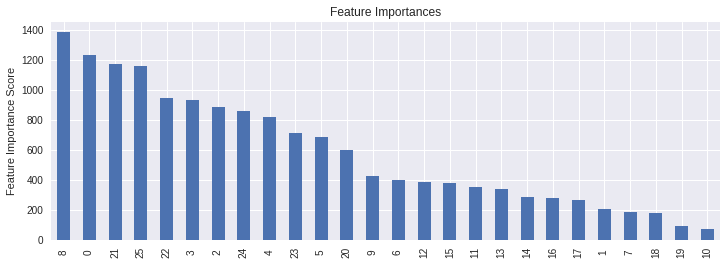

In [59]:
xgb3 = XGBClassifier(
 learning_rate =0.005,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.6,
 reg_alpha=0.88,
 objective= 'binary:logistic',
 nthread=6,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, data_side, predictors)

In [55]:
param = {'max_depth':3,
         'alpha':0.88,
         'eta':0.01, 
         'silent':1,
         'gamma':0.1,
         'scale_pos_weight':1,
         'colsample_bytree':0.6,
         'subsample':0.8,
         'min_child_weight':12
        }
param['nthread'] = 6
param['eval_metric'] = 'logloss'
param['objective']='binary:logistic'

In [57]:
num_round = 2000
bst = xgb.train(param, dtrain, num_round, evallist )

[0]	eval-logloss:0.68815	train-logloss:0.688119
[1]	eval-logloss:0.683333	train-logloss:0.683274
[2]	eval-logloss:0.678653	train-logloss:0.678551
[3]	eval-logloss:0.673943	train-logloss:0.673836
[4]	eval-logloss:0.66931	train-logloss:0.669197
[5]	eval-logloss:0.66476	train-logloss:0.664634
[6]	eval-logloss:0.660302	train-logloss:0.660154
[7]	eval-logloss:0.655959	train-logloss:0.655783
[8]	eval-logloss:0.651703	train-logloss:0.65149
[9]	eval-logloss:0.647506	train-logloss:0.64728
[10]	eval-logloss:0.643402	train-logloss:0.643157
[11]	eval-logloss:0.639415	train-logloss:0.639142
[12]	eval-logloss:0.635435	train-logloss:0.63515
[13]	eval-logloss:0.631522	train-logloss:0.631223
[14]	eval-logloss:0.627705	train-logloss:0.627384
[15]	eval-logloss:0.623932	train-logloss:0.62361
[16]	eval-logloss:0.620233	train-logloss:0.619893
[17]	eval-logloss:0.616614	train-logloss:0.616253
[18]	eval-logloss:0.613089	train-logloss:0.612707
[19]	eval-logloss:0.609582	train-logloss:0.609174
[20]	eval-logloss

## Using XGBoostClassifier 


In [30]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.X, label=dtrain.y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    print cvresult
    #Fit the algorithm on the data
    alg.fit(dtrain.df_X[predictors], dtrain.df_y ,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict_proba(dtrain.df_X[predictors])
    dtrain_predprob = alg.predict_proba(dtrain.df_X[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "logloss : %.4g" % metrics.log_loss(dtrain.df_y, dtrain_predictions)
    print "logloss (Train): %f" % metrics.log_loss(dtrain.df_y , dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [39]:
data_side.df_X = pd.DataFrame(data_side.X)
data_side.df_y = pd.DataFrame(data_side.y)
predictors = [x for x in data_side.df_X.columns]

    test-logloss-mean  test-logloss-std  train-logloss-mean  train-logloss-std
0            0.644748          0.000278            0.644088           0.000194
1            0.605053          0.000690            0.603807           0.000356
2            0.572317          0.001052            0.570454           0.000588
3            0.544747          0.001397            0.542335           0.000548
4            0.521552          0.001408            0.518509           0.000628
5            0.501734          0.001597            0.498068           0.000647
6            0.485071          0.001929            0.480821           0.000791
7            0.470752          0.002158            0.465956           0.000833
8            0.458460          0.002318            0.453109           0.000772
9            0.447860          0.002446            0.442001           0.000844
10           0.438691          0.002457            0.432346           0.000829
11           0.430862          0.002578            0

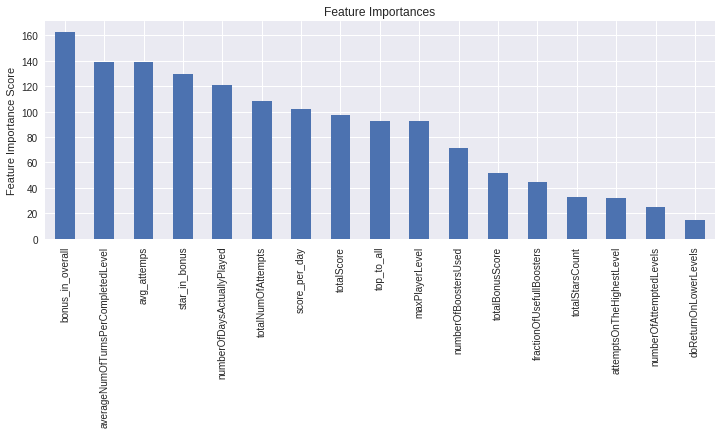

In [12]:
#Choose all predictors except target & IDcols

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=6,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1,data_side, predictors)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
params ={ 'learning_rate' :0.1, 
         'n_estimators':140,
         'max_depth':5,
         'min_child_weight':1,
         'gamma':0, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'objective': 'binary:logistic', 
         'nthread':4,
         'scale_pos_weight':1,
         'seed':27
        }
estim = XGBClassifier(params)
gsearch1 =GridSearchCV(estimator = estim, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=6,iid=False, cv=5,verbose=1)
    
gsearch1.fit(data_side.X,data_side.y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [47]:
bst.save_model('0001.model')

### Output

In [78]:
x_test = pd.read_csv('x_test.csv',';')
x_ts=Data( gen_new_features(x_test),data.y)
x_tsl =  gen_log_features_fordata(x_ts)

x_tsl= data_side.scaler.transform(x_tsl.X)

#x_test= data.scaler.transform(x_test)
a= [6 , 8 , 24, 25, 20, 21, 22, 23, 0 , 2 , 4 , 7 , 9 , 11, 10, 13, 12, 15, 14, 17, 16, 19, 18, 1 , 3 , 5]
dtest = xgb.DMatrix(x_tsl,label=a)
dd = pd.DataFrame(x_tsl)
dd.labels=a
y_res = xgb2.predict_proba(dd)[:,1]
print y_res

y_stay = pd.DataFrame(y_res)
y_stay.describe()

[ 0.1343327   0.02451255  0.58199543 ...,  0.0552364   0.28477937
  0.02903173]


,0
count,25289.000000
mean,0.287314
std,0.288983
min,0.022535
25%,0.052855
50%,0.155217
75%,0.490315
max,0.979051


In [79]:
y_stay.to_csv('results_XGB3.csv',index=False,header=False)

In [11]:
def learning_curves(X,y,clf):
    rates_tr = []
    rates_ts = []
    row = np.arange(0.01,1,0.05)
    for r in row:
        x_train,x_test,y_train,y_test = sk.model_selection.train_test_split(X,y,test_size=r)
        clf.fit(x_train,y_train)
        pred_train=clf.predict_proba(x_train)
        pred_test=clf.predict_proba(x_test)
        rates_tr.append(-sk.metrics.log_loss(y_train,pred_train))
        rates_ts.append(-sk.metrics.log_loss(y_test,pred_test))
    plt.plot(row,rates_tr,label='train')
    plt.plot(row,rates_ts,label='test')
    plt.legend()
        